<a href="https://colab.research.google.com/github/michaelyoung1997/Development-of-AI-tools-to-link-climate-and-land-usage/blob/master/Surface_Temperature_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install libtiff 
from libtiff import TIFF
from scipy.ndimage import gaussian_filter
from libtiff import TIFF

!pip install pyproj 
from pyproj import Transformer 

import ee 
ee.Authenticate()
ee.Initialize()

from sklearn.preprocessing import OneHotEncoder 

!pip install rasterio 
import rasterio

import cv2 



**Specify File Path**

In [6]:
path='/content/drive/My Drive/Project/'

**Import Stuff**

In [5]:
land_use=pd.read_csv(path+'landuse_altitudegb.csv', index_col='Stations')
land_use2015gb=pd.read_csv(path+'landuse_2015gb.csv', index_col='Stations')

soil_cover=pd.read_csv(path+'stations_soil.csv', index_col='Station')
inland=pd.read_csv(path+'inland.csv', index_col='Stations')
landmask=np.loadtxt(path+'total_landcover')>80


In [ ]:
# coordinatemap=np.zeros((landmask.shape[0], landmask.shape[1])).tolist()
# for i in range(landmask.shape[0]):
#   for j in range(landmask.shape[1]):
#     coordinatemap[i][j]=tuple([i,j])

land_use

,Easting,Northing,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens,Sum,Land,Altitude
Stations,,,,,,,,,,,,,,,
23,348236,1007709,0.0000,0.1250,2.9375,28.4375,37.0000,24.8750,1.7500,0.2500,0.0000,2.1250,97.5000,1,27.0
18903,76312,842502,0.0000,0.0000,0.0000,2.4375,10.7500,0.5000,0.0000,8.5000,53.1875,0.0000,75.3750,1,3.0
54,146443,933104,0.0000,0.1250,1.8750,20.4375,47.0000,10.1875,0.1875,0.3125,3.8750,7.8125,91.8125,1,14.0
67,227669,874255,37.6875,0.7500,0.0000,0.0000,6.9375,51.0000,0.0000,3.4375,0.0000,0.0000,99.8125,1,267.0
52,184575,891274,1.1250,0.6250,0.0000,8.8125,4.0625,17.4375,0.6250,0.3750,3.7500,0.1250,36.9375,1,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13343,209600,542600,14.8750,5.9375,16.1250,47.0000,8.4375,0.0000,0.3750,1.8750,0.4375,0.8125,95.8750,1,31.0
30273,336300,162800,2.0625,0.2500,9.8750,12.3125,1.3750,0.0000,0.0000,0.2500,0.0000,73.6875,99.8125,1,6.0
30137,225516,911619,1.6250,28.5000,0.0000,3.6875,19.3750,38.1875,0.0000,8.6250,0.0000,0.0000,100.0000,1,148.0


**Generate random samples**

In [ ]:
# Startified Random Sampling across UK landmask ensures no duplicate points and reduces neighbouring points


def euclidean_dist(coord1):
  return np.sqrt((coord1[0]-coordinate[0])**2 + (coord1[1]-coordinate[1])**2)

coordinates=[]
while len(coordinates)<20000:
  i=np.random.randint(0,1300)
  j=np.random.randint(0,700)
  coordinate=[i,j]
  if (landmask[i,j] and min(list(map(euclidean_dist, coordinates)))>1.5) or len(coordinates)==0:
    coordinates.append(tuple([i,j]))

  if len(coordinates)%1000==0:
    print(len(coordinates))


1000
1000
1000
2000
3000
3000
3000
3000
3000
4000
4000
4000
4000
4000
4000
5000
5000
5000
5000
5000
5000
5000
5000
6000
6000
6000
6000
6000
6000
6000
6000
6000
6000
7000
7000
7000
7000
7000
7000
7000
8000
8000
9000
9000
9000
9000
9000
9000
10000
10000
10000
10000
10000
10000
10000
11000
11000
11000
11000
11000
12000
12000
12000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
13000
14000
14000
14000
14000
15000
15000
16000
16000
16000
16000
16000
16000
16000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
17000
18000
18000
18000
19000
19000
19000
19000
19000
19000
19000
20000


In [ ]:
coordinates10k=np.loadtxt(path+'generated_stations10k')


**Generate 2007 LC**

In [ ]:
def get_values7(im, dataframe):
  Easting=dataframe['Easting']
  Northing=dataframe['Northing']
  lci=[]
  gim=gaussian_filter(im, sigma=15)
  # gim=im
  for row in dataframe.index:
    e=int(Easting[row])
    n=int(Northing[row])

    if e>im.shape[1] or n>im.shape[0]:
      lci.append(-1000)
    else: 
      lci.append(gim[n,e])
      # lci.append(gaussian_blur(im, n, e))

  return lci

In [ ]:
generated_data=pd.DataFrame(data=coordinates10k, columns=['Northing', 'Easting'])
dummy=[] 
class_list=['1.tif', '2.tif', '3.tif', '4.tif', '5.tif', '6.tif', '7.tif', '8.tif', '9.tif', '10.tif']

for classes in class_list: 
  raster_grid = TIFF.open(str(path+'Land Cover 1km/lcm-2007-1km_3525792/percentage_aggregate_class/LCM2007_GB_1K_PC_AggregateClass_'+classes)).read_image()   


  dummy.append(np.array(get_values7(raster_grid, generated_data)))


for i in range(len(dummy)): 
  generated_data[i]=dummy[i] 
    

generated_data.rename(columns={0: 'Broadleaf woodland', 1:'Coniferous woodland', 2:'Arable ', 3:'Improved Grassland', 4:'Semi-natural grassland', 5:'Mountain Heath', 6:'Saltwater', 7:'Freshwater', 8:'Coastal', 9:'Built-up/gardens'}, inplace=True)
col_list= list(generated_data)
col_list.remove('Easting')
col_list.remove('Northing')
generated_data['Sum']=generated_data[col_list].sum(axis=1)
generated_data['Land']=sum([generated_data['Sum']>0] )




generated_data


,Northing,Easting,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens,Sum,Land
0,661.0,348.0,4,11,23,17,24,13,0,0,0,0,92,1
1,849.0,367.0,4,1,2,45,14,18,0,0,1,5,90,1
2,866.0,369.0,5,1,6,42,12,12,0,0,0,13,91,1
3,1059.0,336.0,5,3,39,27,14,3,0,0,0,1,92,1
4,1085.0,525.0,9,0,43,22,1,0,0,0,0,20,95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1190.0,539.0,8,0,17,31,2,0,0,0,0,6,64,1
9996,548.0,303.0,3,14,9,14,14,37,0,0,0,0,91,1
9997,1173.0,272.0,7,2,17,49,8,1,0,0,0,0,84,1
9998,1007.0,397.0,4,1,33,21,1,0,0,0,0,32,92,1


**Generate 2015 Land Cover Map**

In [ ]:
raster_2015=TIFF.open(path+'Land Cover 1km/LCM2015_GB_1km_percent_cover_aggregate_class.tif').read_image() 

generated_data15=pd.DataFrame(data=coordinates10k, columns=['Northing', 'Easting'])
dummy=[] 

for i in range(raster_2015.shape[2]): 
  raster_grid = raster_2015[:,:,i]
  dummy.append(np.array(get_values7(raster_grid, generated_data15)))


for i in range(len(dummy)): 
  generated_data15[i]=dummy[i] 
    

generated_data15.rename(columns={0: 'Broadleaf woodland', 1:'Coniferous woodland', 2:'Arable ', 3:'Improved Grassland', 4:'Semi-natural grassland', 5:'Mountain Heath', 6:'Saltwater', 7:'Freshwater', 8:'Coastal', 9:'Built-up/gardens'}, inplace=True)
col_list= list(generated_data15)
col_list.remove('Easting')
col_list.remove('Northing')


In [ ]:
generated_data15

,Northing,Easting,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens
0,95.0,672.0,0,0,0,0,0,0,0,0,0,0
1,668.0,326.0,0,18,0,5,38,33,0,0,0,0
2,823.0,447.0,4,0,68,20,0,0,0,0,0,2
3,487.0,297.0,3,37,0,3,2,47,0,1,0,0
4,939.0,555.0,0,0,39,6,0,0,1,0,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1009.0,328.0,4,3,14,53,19,0,0,0,0,0
19996,1088.0,224.0,7,1,4,63,0,0,0,0,6,1
19997,974.0,510.0,4,0,76,12,0,0,0,0,0,3
19998,446.0,304.0,10,42,12,21,0,7,0,0,0,1


**Generate GEE Land Cover Map**

In [ ]:
lc_gee=pd.read_csv('/content/drive/My Drive/land_cover_1000_2.csv')
lc_gee

lc_index=[]
for item in list(lc_gee['system:index']):
  st=str(item)
  lc_index.append(st[:-2])
lc_gee.index=lc_index
lc_gee.index=lc_gee.index.astype(int)
lc_gee.drop(['system:index', '.geo'], axis=1, inplace=True)
lc_gee

,bare-coverfraction,crops-coverfraction,grass-coverfraction,moss-coverfraction,shrub-coverfraction,snow-coverfraction,tree-coverfraction,urban-coverfraction,water-permanent-coverfraction,water-seasonal-coverfraction
0,3.0,1.0,80.0,0.0,13.0,0.0,5.0,0.0,0.0,0.0
1,1.0,3.0,72.0,0.0,11.0,0.0,15.0,0.0,0.0,0.0
2,0.0,8.0,65.0,0.0,10.0,0.0,19.0,0.0,0.0,0.0
3,0.0,16.0,59.0,0.0,8.0,0.0,19.0,1.0,0.0,0.0
4,1.0,42.0,34.0,0.0,4.0,0.0,17.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,82.0,2.0,0.0,9.0,0.0,9.0,0.0,0.0,0.0
9996,0.0,0.0,54.0,0.0,16.0,0.0,32.0,0.0,0.0,0.0
9997,0.0,18.0,51.0,0.0,9.0,0.0,21.0,3.0,0.0,0.0
9998,0.0,0.0,2.0,0.0,1.0,0.0,2.0,96.0,0.0,0.0


**Transform from British National Grid to Latitude Longitude**

In [ ]:
transformer = Transformer.from_crs("epsg:27700", "epsg:4326")

global_points=(np.array(transformer.transform(list(generated_data['Easting']*1000), list(1300000-generated_data['Northing']*1000))).T)
global_points=np.flip(global_points,1) 
global_points=global_points.tolist() 

In [ ]:
with open("/content/drive/My Drive/Project/global_points20k.txt", "w") as output:
    output.write(str(global_points))

**Format CSV files**

In [ ]:
def format_csv(series, name):
  index=[]
  for item in list(series['system:index']):
    st=str(item)
    index.append(st[:-2])
  series.index=index
  series.index=series.index.astype(int)
  series.rename(columns={str(series.columns[1]):str(name)}, inplace=True) 
  return series 

In [ ]:
feb2007=pd.read_csv(path+'LST_Feb_10k.csv')
feb2007=format_csv(feb2007, 'Feb_2007_LST')

july2007=pd.read_csv(path+'LST_July_10k.csv')
july2007=format_csv(july2007, 'Jul_2007_LST')

nov2007=pd.read_csv(path+'LST_Nov_10k.csv')
nov2007=format_csv(nov2007, 'Nov_2007_LST')



elevation=pd.read_csv(path+'altitude_10k.csv')
elevation=format_csv(elevation, 'elevation')

pop_density=pd.read_csv('/content/drive/My Drive/population_ts2.csv')
pop_density=format_csv(pop_density, 'pop_density')



feb_evi=pd.read_csv(path+'EVI_Feb_10k.csv')
feb_evi=format_csv(feb_evi, 'Feb_2007_EVI')

july_evi=pd.read_csv(path+'EVI_July_10k.csv')
july_evi=format_csv(july_evi, 'Jul_2007_EVI')

nov_evi=pd.read_csv(path+'EVI_Feb_10k.csv')
nov_evi=format_csv(nov_evi, 'Nov_2007_EVI')



feb_lst15=pd.read_csv(path+'LST_FEB_25.csv')
feb_lst15=format_csv(feb_lst15, 'Feb_2015_LST')

july_lst15=pd.read_csv(path+'LST_Jul_15.csv')
july_lst15=format_csv(july_lst15, 'Jul_2015_LST')

nov_lst15=pd.read_csv(path+'LST_Nov_15.csv')
nov_lst15=format_csv(nov_lst15, 'Nov_2015_LST')




feb_evi15=pd.read_csv(path+'EVI_Feb_15.csv')
feb_evi15=format_csv(feb_evi15, 'Feb_2015_EVI')

july_evi15=pd.read_csv(path+'EVI_July_15.csv')
july_evi15=format_csv(july_evi15, 'Jul_2015_EVI')

nov_evi15=pd.read_csv(path+'EVI_Nov_15.csv')
nov_evi15=format_csv(nov_evi15, 'Nov_2015_EVI')



lst_2007=pd.read_csv(path+'LST_2007.csv')
lst_2007=format_csv(lst_2007, 'LST_2007')

lst_2015=pd.read_csv(path+'LST_2015.csv')
lst_2015=format_csv(lst_2015, 'LST_2015')


evi_2007=pd.read_csv(path+'EVI_2007.csv')
evi_2007=format_csv(evi_2007, 'EVI_2007')

evi_2015=pd.read_csv(path+'EVI_2015.csv')
evi_2015=format_csv(evi_2015, 'EVI_2015')

croptype=pd.read_csv(path+'crop-type.csv')
croptype=format_csv(croptype, 'croptype')

In [ ]:


ohc=OneHotEncoder() 
ohc.fit(np.asarray(croptype['croptype']).reshape(-1,1))

ohc_crop=ohc.transform(np.asarray(croptype['croptype']).reshape(-1,1)).toarray()[:,0:]
crops=pd.DataFrame(data=ohc_crop, index=generated_data.index, columns=['Non-croplands', 'Irrigation_major',  'Irrigation_minor', 'Rainfed', 'Rainfed_minorfragments', 'Rainfed_veryminorfragments'])

crops.to_csv(path+'crops.csv')

**Calculate distance of each station from coast** 

In [ ]:
# import cv2 
# plt.figure(figsize=(8,12))
# total=np.loadtxt(path+'total_landcover')

# gb=cv2.GaussianBlur(total,(3,3),0)
# im=cv2.Sobel(gb,cv2.CV_64F,1,1,ksize=5) #+ cv2.Sobel(gb,cv2.CV_64F,1,0,ksize=5)
# plt.imshow(im>200, cmap='gray')


# y,x=np.where(im>200)
# y=np.subtract(1300, y)

# y.shape
# coastlines=[]
# for i in range(len(x)):
#   coastlines.append(tuple([x[i], y[i]]))


# easting=list(generated_data['Easting'])
# northing=list(generated_data['Northing'])

# station_coords=[]
# for i in range(len(easting)):
#   station_coords.append(tuple([easting[i], northing[i]]))

# station=station_coords[0]

# def euclidean_dist(c):
#   return np.sqrt((c[0]-station[0])**2 + (c[1]-station[1])**2) 
  
# inland=[]
# for station in station_coords: 
#   inland.append(min(map(euclidean_dist, coastlines)))

# inland=pd.Series(inland, index=generated_data.index, name='Inland')
inland=pd.read_csv(path+'inland_10k.csv')
  

**Altitude Topographical feature** 

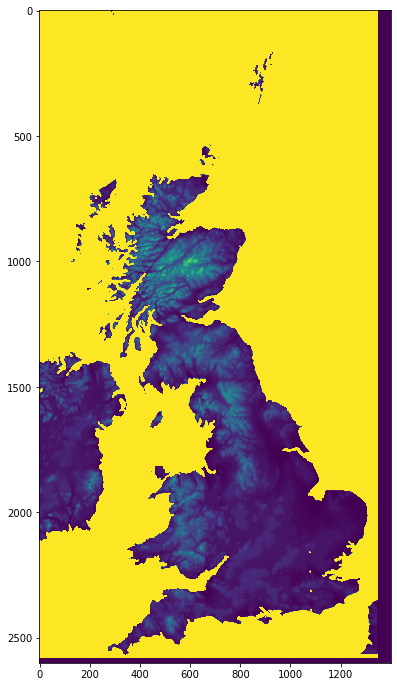

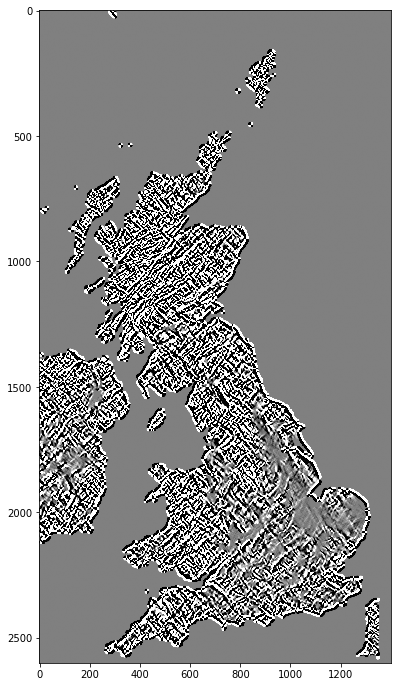

In [ ]:
raster_bng = rasterio.open(path+'uk_dem_bng2.tif').read(1)
plt.figure(figsize=(20,12))
plt.imshow(raster_bng, vmin=1, vmax=1326)

import cv2 
plt.figure(figsize=(8,12))
gb=gaussian_filter(raster_bng, sigma=1)
im=cv2.Sobel(gb, cv2.CV_64F,1,1,ksize=7) 
plt.imshow(im, cmap='gray', vmax=200, vmin=-200)

topography=[]
for row in generated_data.index:
  n=int(generated_data['Northing'][row]*2)
  e=int(generated_data['Easting'][row]*2)
  topography.append(im[n,e])

topography_gb=pd.Series(topography, index=generated_data.index, name='topography_sobel')

In [ ]:
topography_gb.to_csv(path+'topographygb.csv')

In [ ]:
topography_sobel=((topography_gb-topography_gb.min())/(topography_gb.max()-topography_gb.min()))
topography_sobel.to_csv(path+'topographygb.csv')

**Gaussian Blur Topography Feature** 

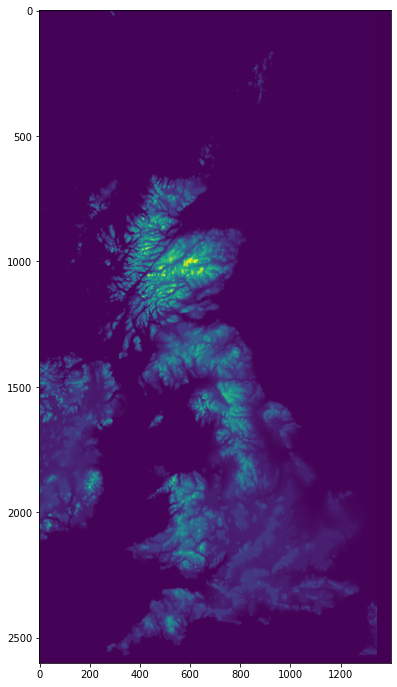

In [ ]:
im = rasterio.open(path+'uk_dem_bng2.tif').read(1)
plt.figure(figsize=(20,12))
im=np.where(im>3200, 0, im)
plt.imshow(im)

gim=gaussian_filter(im, sigma=15)

np.max(gim)
plt.imshow(im, vmin=-10, vmax=1000)
# plt.scatter(generated_data['Easting']*2, generated_data['Northing']*2)
topography2=[]

for row in generated_data.index:
  n=int(generated_data['Northing'][row]*2)
  e=int(generated_data['Easting'][row]*2)
  topography2.append(im[n,e]-gim[n,e])

topography2=pd.Series(data=topography2, name='topography4')
topography2.to_csv(path+'topography4_gb15.csv')

**Load Soil Data** 

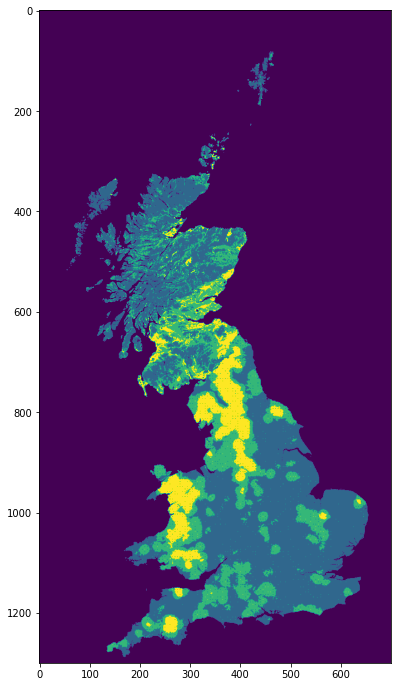

In [ ]:
england_soil=np.asarray(rasterio.open(path+'england_soil2.tif').read(1))
scotland_soil=np.asarray(rasterio.open(path+'scotland_soil.tif').read(1)) 

#rearrange classes to match UK 
scotland_soil=np.where(scotland_soil>0, 4-scotland_soil, scotland_soil)


uk_soil=np.zeros(scotland_soil.shape)

for i in range(uk_soil.shape[0]):
  for j in range(uk_soil.shape[1]):
    if int(scotland_soil[i,j])==0 or int(england_soil[i,j])==0:
      uk_soil[i,j]=int(scotland_soil[i,j]+england_soil[i,j])
    elif int(scotland_soil[i,j])!=0 and int(england_soil[i,j])!=0:
      uk_soil[i,j]=int(england_soil[i,j])

plt.figure(figsize=(20,12))
plt.imshow(uk_soil)

In [ ]:
soil=[]
for row in generated_data.index:
  n=int(generated_data['Northing'][row])
  e=int(generated_data['Easting'][row])
  soil.append(int(uk_soil[n,e]))

 

ohc=OneHotEncoder() 
ohc.fit(np.asarray(soil).reshape(-1,1))
ohc_soil=ohc.transform(np.asarray(soil).reshape(-1,1)).toarray()[:,1:]
soil=pd.DataFrame(data=ohc_soil, index=generated_data.index, columns=['Mineral', 'Organic Mineral', 'Organic'])
soil

,Mineral,Organic Mineral,Organic
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
9995,0.0,1.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,1.0,0.0,0.0


**Compile into dataframes** 

In [ ]:
# lst_both=pd.concat([generated_data, elevation['elevation'], pop_density['pop_density'], feb_evi['Feb_2007_EVI'], july_evi['Jul_2007_EVI'], nov_evi['Nov_2007_EVI'], feb_evi15['Feb_2015_EVI'], july_evi15['Jul_2015_EVI'], nov_evi15['Nov_2015_EVI'], inland, topography_gb, soil['Mineral'], soil['Organic Mineral'], soil['Organic']], axis=1, join='inner').drop(['Sum', 'Land', 'Unnamed: 0'], axis=1)

# lst07_gee=pd.concat([generated_data[['Northing', 'Easting']], lc_gee, elevation['elevation'], pop_density['pop_density'], feb_evi['Feb_2007_EVI'], july_evi['Jul_2007_EVI'], nov_evi['Nov_2007_EVI'], inland, topography_gb, soil['Mineral'], soil['Organic Mineral'], soil['Organic']], axis=1, join='inner').drop(['Unnamed: 0'], axis=1)

lst07=pd.concat([generated_data, elevation['elevation'], pop_density['pop_density'], feb_evi['Feb_2007_EVI'], july_evi['Jul_2007_EVI'], nov_evi['Nov_2007_EVI'], inland['Inland'], topography_gb, soil['Mineral'], soil['Organic Mineral'], soil['Organic']], axis=1, join='inner').drop(['Sum', 'Land'], axis=1)

lst15=pd.concat([generated_data15, elevation['elevation'], pop_density['pop_density'], feb_evi15['Feb_2015_EVI'], july_evi15['Jul_2015_EVI'], nov_evi15['Nov_2015_EVI'], inland['Inland'], topography_gb, soil['Mineral'], soil['Organic Mineral'], soil['Organic']], axis=1, join='inner').drop([ ], axis=1)

# targets=pd.concat([feb2007['Feb_2007_LST'], july2007['Jul_2007_LST'], nov2007['Nov_2007_LST'], feb_lst15['Feb_2015_LST'], july_lst15['Jul_2015_LST'], nov_lst15['Nov_2015_LST'], lst_2007['LST_2007'], lst_2015['LST_2015']], axis=1, join='inner') 


# lst07_gee


In [ ]:
lst15_smallblur=pd.concat([generated_data15, elevation['elevation'], pop_density['pop_density'], feb_evi15['Feb_2015_EVI'], july_evi15['Jul_2015_EVI'], nov_evi15['Nov_2015_EVI'], inland, topography_gb, soil['Mineral'], soil['Organic Mineral'], soil['Organic']], axis=1, join='inner').drop([ 'Unnamed: 0'], axis=1)


In [ ]:
# lst_both.to_csv(path+'lst_both.csv')
# lst07_gee.to_csv(path+'lst07_gee.csv')
lst07.to_csv(path+'lst07_gb15.csv')
lst15.to_csv(path+'lst15_gb15.csv')
# targets.to_csv(path+'targets.csv')

In [ ]:
lst15_smallblur.to_csv(path+'lst15_smallblur.csv')


In [ ]:
lst=pd.read_csv(path+'lst_10k_gb35_gb.csv')
lst

,Unnamed: 0,Northing,Easting,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens,elevation,population_density,feb_EVI,july_EVI,Inland,Feb_2007_LST,July_2007_LST,topography,Mineral,Organic Mineral,Organic
0,0,661.0,348.0,5,9,15,29,27,6,0,0,0,3,224,2.820140,0.237948,0.350908,38.013156,13927.727273,14543.400000,142.0,0.0,1.0,0.0
1,1,849.0,367.0,6,3,0,40,18,27,0,0,0,0,160,3.071964,0.137649,0.308139,29.966648,13992.666667,14504.200000,281.0,0.0,1.0,0.0
2,2,866.0,369.0,7,0,2,59,7,0,0,0,0,17,101,89.064470,0.238271,0.223778,38.600518,13950.444444,14162.000000,28.0,0.0,1.0,0.0
3,3,1059.0,336.0,7,2,58,17,8,0,0,0,0,0,87,18.957787,0.126493,0.335886,53.851648,13891.555556,14670.555556,-59.0,1.0,0.0,0.0
4,4,1085.0,525.0,14,0,35,25,0,0,0,0,0,20,62,627.128300,0.149533,0.266729,67.475922,13929.000000,14715.000000,-22.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9651,9995,1190.0,539.0,5,0,26,53,3,0,0,0,0,7,86,472.045070,0.240806,0.291955,5.830952,14019.375000,14667.666667,274.0,0.0,1.0,0.0
9652,9996,548.0,303.0,3,8,2,10,13,57,0,1,0,0,358,2.517340,0.124496,0.253098,47.885280,13843.800000,14507.333333,-142.0,1.0,0.0,0.0
9653,9997,1173.0,272.0,7,2,15,65,3,0,0,0,0,1,109,22.139850,0.196956,0.270083,22.847319,14058.750000,14656.000000,-27.0,1.0,0.0,0.0
9654,9998,1007.0,397.0,2,0,3,11,0,0,0,0,0,80,131,4554.672400,0.070320,0.166667,113.718952,13994.857143,14806.222222,19.0,1.0,0.0,0.0
